In [2]:
import numpy as np
from utils.dataset import Signals
def generate_mixed_signal_data(num_samples=10000, sample_length=4096, frequency_range=(10, 1000), amplitude_range=(1, 10), snr_range=(-20, -5)):
    """
    生成混合信号数据集，包括正弦波形和复合波形，具有不同的频率和幅值，以及不同的信噪比。
    :param num_samples: 生成的样本数量
    :param sample_length: 每个样本的长度
    :param frequency_range: 频率范围，以Hz为单位
    :param amplitude_range: 幅值范围
    :param snr_range: 信噪比范围，以dB为单位
    :return: 原始信号和带噪声的信号
    """
    signals = np.zeros((num_samples, sample_length), dtype=np.float16)
    noisy_signals = np.zeros((num_samples, sample_length), dtype=np.float16)
    t = np.linspace(0, 1, sample_length, dtype=np.float16)

    for i in range(num_samples):
        # 随机选择频率和幅值
        frequency = np.random.uniform(*frequency_range)
        amplitude = np.random.uniform(*amplitude_range)

        # 生成正弦波信号或复合信号
        if np.random.rand() > 0.5:
            # 生成正弦波信号
            signal = amplitude * np.sin(2 * np.pi * frequency * t)
        else:
            # 生成复合信号
            signal = amplitude * (np.sin(2 * np.pi * frequency * t) + np.sin(2 * np.pi * 0.5 * frequency * t))

        # 计算信号功率
        signal_power = np.mean(signal ** 2)

        # 随机选择信噪比
        snr_db = np.random.uniform(*snr_range)
        snr_linear = 10 ** (snr_db / 10)
        noise_power = signal_power / snr_linear

        # 生成噪声并添加到信号上
        noise = np.random.normal(0, np.sqrt(noise_power), signal.shape).astype(np.float16)
        noisy_signal = signal + noise

        signals[i] = signal
        noisy_signals[i] = noisy_signal

    return signals, noisy_signals

# 生成数据
signals, noisy_signals = generate_mixed_signal_data()
# dataSet = Signals('./data', slice_length=512, slice_type='cut')
# noisy_dataSet = Signals('./data', slice_length=512, slice_type='cut', add_noise=True)
# 示例：查看数据尺寸
print("Signals shape:", signals.shape)
print("Noisy signals shape:", noisy_signals.shape)


Signals shape: (10000, 4096)
Noisy signals shape: (10000, 4096)


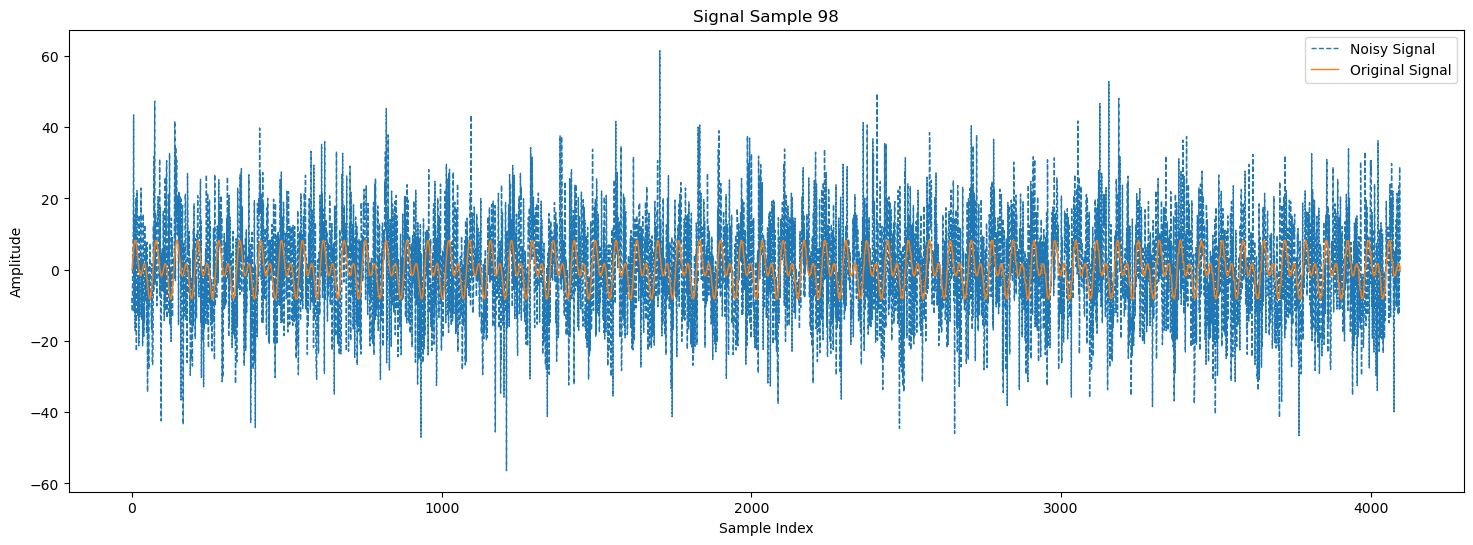

In [3]:
import matplotlib.pyplot as plt

# 从生成的数据中随机选择一组进行可视化
sample_index = np.random.randint(0, 100)  # 随机选择一个样本索引

# 绘制原始信号和带噪声的信号
plt.figure(figsize=(18, 6))
plt.plot(noisy_signals[sample_index], label='Noisy Signal', linestyle='--', linewidth=1)
plt.plot(signals[sample_index], label='Original Signal', linewidth=1)
plt.title(f"Signal Sample {sample_index}")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


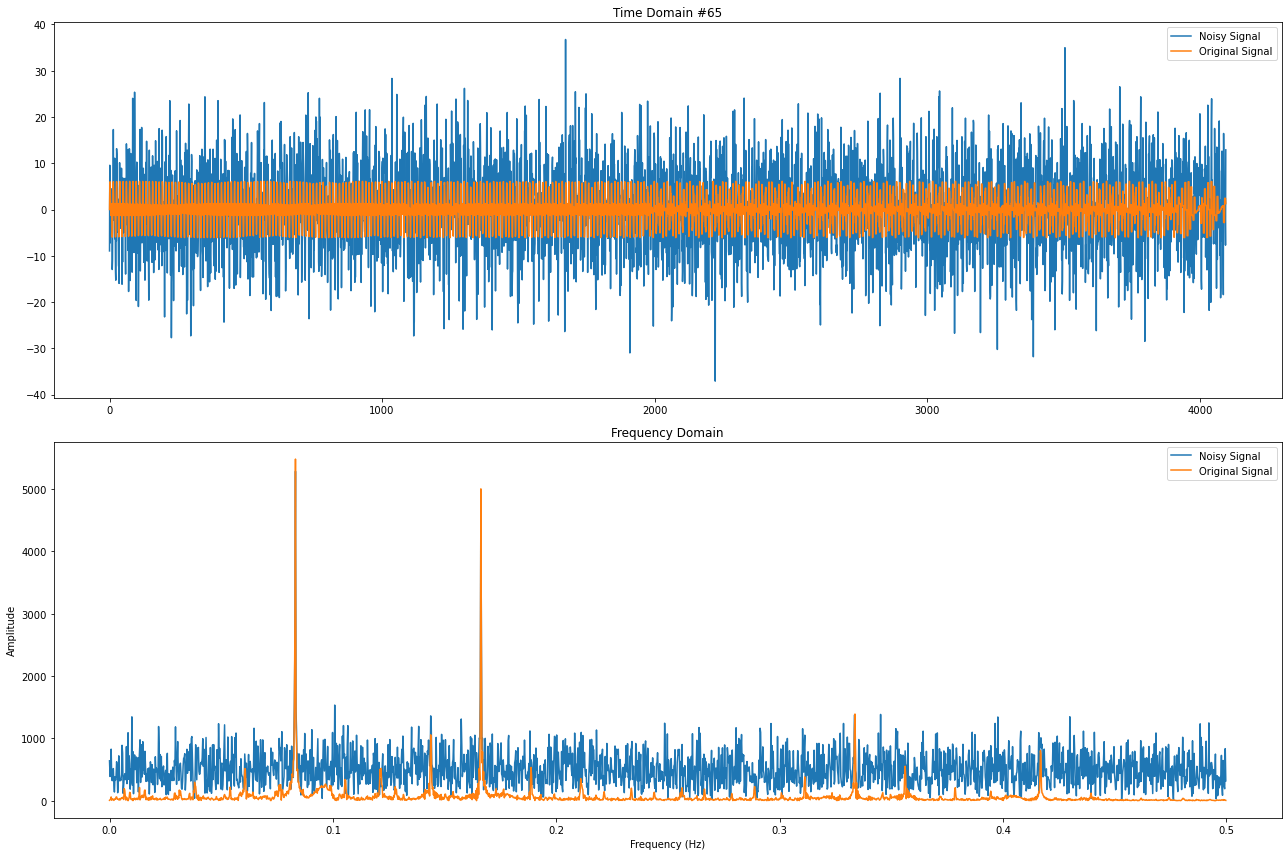

In [10]:
import matplotlib.pyplot as plt

# 随机选择一个样本进行可视化
sample_index = np.random.randint(0, 100)

# 可视化时域信号
plt.figure(figsize=(18, 12))
plt.subplot(2, 1, 1)
plt.plot(noisy_signals[sample_index], label='Noisy Signal')
plt.plot(signals[sample_index], label='Original Signal')
plt.legend()
plt.title(f"Time Domain #{sample_index}")

# 计算并可视化频率成分
signal_fft = np.fft.fft(signals[sample_index])
noisy_signal_fft = np.fft.fft(noisy_signals[sample_index])
freq = np.fft.fftfreq(signals[sample_index].shape[-1])


# 计算正频率部分
n = signals[sample_index].size
timestep = 1.0  # 假设采样时间间隔为1秒
freq = np.fft.fftfreq(n, d=timestep)[:n//2]

# FFT变换后只取正频率部分
signal_fft = np.fft.fft(signals[sample_index])[:n//2]
noisy_signal_fft = np.fft.fft(noisy_signals[sample_index])[:n//2]

plt.subplot(2, 1, 2)
plt.plot(freq, np.abs(noisy_signal_fft), label='Noisy Signal')
plt.plot(freq, np.abs(signal_fft), label='Original Signal')
plt.legend()
plt.title('Frequency Domain')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()



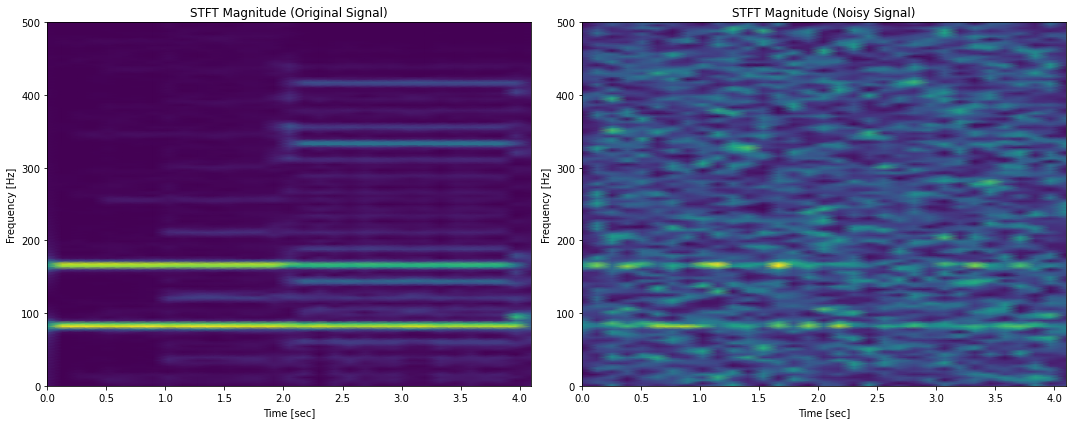

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft

# 短时傅里叶变换(STFT)参数
nperseg = 256
fs = 1000  # 采样频率
t = np.arange(0, 1, 1/fs)  # 时间向量

# 对原始信号和加噪声后的信号进行STFT
f_orig, t_orig, Zxx_orig = stft(signals[sample_index], fs, nperseg=nperseg)
f_noisy, t_noisy, Zxx_noisy = stft(noisy_signals[sample_index], fs, nperseg=nperseg)

# 绘制原始信号的STFT时频图
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.pcolormesh(t_orig, f_orig, np.abs(Zxx_orig), shading='gouraud')
plt.title('STFT Magnitude (Original Signal)')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

# 绘制加噪声后信号的STFT时频图
plt.subplot(1, 2, 2)
plt.pcolormesh(t_noisy, f_noisy, np.abs(Zxx_noisy), shading='gouraud')
plt.title('STFT Magnitude (Noisy Signal)')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.tight_layout()
plt.show()

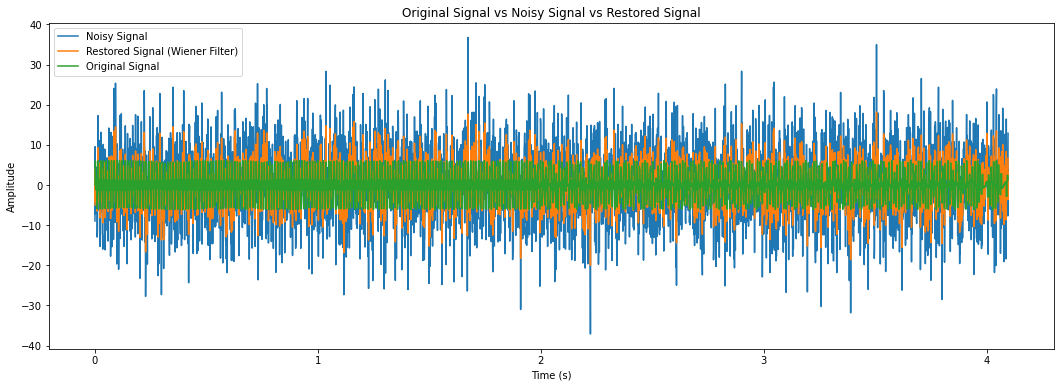

Text(0.5, 0, 'Time [sec]')

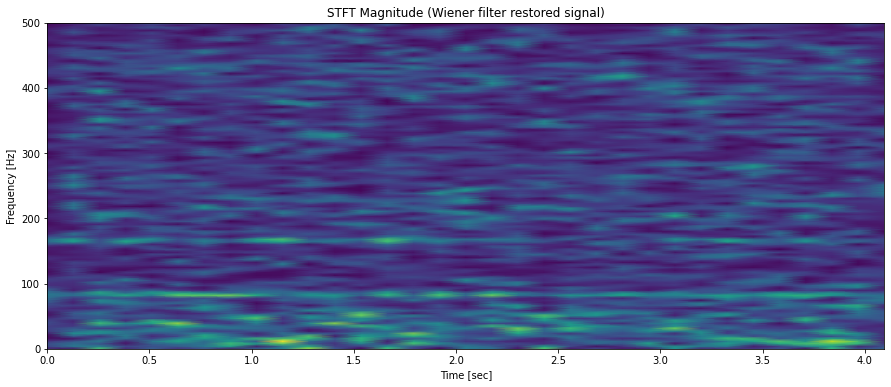

In [40]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# 设置信号参数
Fs = 1000  # 采样频率
T = 1 / Fs  # 采样周期
t = np.arange(0, 4.096, T)  # 时间序列

# 生成正弦信号
# f = 5  # 信号频率
# A = 1  # 信号振幅
# signal = A * np.sin(2 * np.pi * f * t)
signal = signals[sample_index]

# 添加高斯噪声
# noise = np.random.normal(0, 0.5, len(t))  # 均值为0，标准差为0.5的高斯噪声
# noisy_signal = signal + noise
noisy_signal = noisy_signals[sample_index]

# 定义维纳滤波函数
def wiener_filter(noisy_signal, kernel_size=11, noise_var=0.5):
    # 将信号和滤波器转换为PyTorch张量
    noisy_signal_tensor = torch.tensor(noisy_signal, dtype=torch.float32)
    kernel = torch.ones(kernel_size, dtype=torch.float32) / kernel_size
    
    # 对信号进行卷积运算
    filtered_signal = F.conv1d(noisy_signal_tensor.view(1, 1, -1), kernel.view(1, 1, -1), padding=(kernel_size - 1) // 2)
    
    # 计算信噪比
    # snr = torch.var(torch.tensor(signal, dtype=torch.float32)) / torch.var(torch.tensor(noise, dtype=torch.float32))
    snr = 2
    
    # 使用维纳滤波
    restored_signal = filtered_signal.squeeze() + (1 - 1 / snr) * (noisy_signal_tensor - filtered_signal.squeeze())
    
    return restored_signal.numpy()

# 对带噪声的信号应用维纳滤波
restored_signal = wiener_filter(noisy_signal)

# 绘制原始信号、带噪声的信号和处理后的信号
plt.figure(figsize=(18, 6))
plt.plot(t, noisy_signal, label='Noisy Signal')
plt.plot(t, restored_signal, label='Restored Signal (Wiener Filter)')
plt.plot(t, signal, label='Original Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original Signal vs Noisy Signal vs Restored Signal')
plt.legend()
plt.show()


# 短时傅里叶变换(STFT)参数
nperseg = 256
fs = 1000  # 采样频率
t = np.arange(0, 1, 1/fs)  # 时间向量

f_restored, t_restored, Zxx_restored = stft(restored_signal, fs, nperseg=nperseg)
# 绘制原始信号的STFT时频图
plt.figure(figsize=(15, 6))
plt.pcolormesh(t_restored, f_restored, np.abs(Zxx_restored), shading='gouraud')
plt.title('STFT Magnitude (Wiener filter restored signal)')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')